In [18]:
import functools
import glob
import itertools
import json
import operator
import os
import re
import xml.etree.ElementTree as ET
from collections import Counter, namedtuple, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import requests
from bs4 import BeautifulSoup
from pylab import rcParams

rcParams['figure.figsize'] = 10,20

In [19]:
def create_dir_if_doesnt_exist(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)


YEAR = 2009
PATH = 'F:\\saos\\data\\json\\judgments-*'
HELPERS_DIR = 'helpers'
API_RESULTS_DIR = 'api_results'

create_dir_if_doesnt_exist(HELPERS_DIR)
create_dir_if_doesnt_exist(API_RESULTS_DIR)

FILENAMES_FOR_YEAR = os.path.join(HELPERS_DIR, f'judgments_from_{YEAR}.json')
NUMBER_OF_JUDGMENTS = 100
NER_API_BASE_URL = 'http://ws.clarin-pl.eu/nlprest2/base'
NER_API_LPMN_PARAMETER = 'any2txt|wcrft2|liner2({"model":"n82"})'

In [20]:
year_pattern = str(YEAR) + '-\d{2}-\d{2}'


def get_filenames_with_judgments_for_year(judgment_filenames):
    with open(FILENAMES_FOR_YEAR, 'w') as file:
        filenames_for_year = filter(contains_judgments_from_year, judgment_filenames)
        json.dump(list(filenames_for_year), file)


def contains_judgments_from_year(filename):
    return any(re.match(year_pattern, item['judgmentDate']) for item in get_judgments(filename))


def get_judgments(filename):
    with open(filename, encoding='utf-8') as file:
        content = json.load(file)
    judgments = (item for item in content['items'] if re.match(year_pattern, item['judgmentDate']))
    return sorted(judgments, key=operator.itemgetter('judgmentDate'))

In [21]:
all_judgment_filenames = glob.glob(PATH)

if not os.path.isfile(FILENAMES_FOR_YEAR):
    get_filenames_with_judgments_for_year(all_judgment_filenames)

with open(FILENAMES_FOR_YEAR) as file:
    filenames_with_judgments_for_year = json.load(file)
    judgments = list(itertools.chain.from_iterable(map(get_judgments, filenames_with_judgments_for_year)))

In [22]:
def clear_html_from_text(text):
    return BeautifulSoup(text, 'lxml').get_text()

judgment_texts = [clear_html_from_text(judgment['textContent']) for judgment in judgments[:NUMBER_OF_JUDGMENTS]]

In [23]:
len(judgment_texts)

100

In [24]:
def save_api_response(index, text):
    data = {'lpmn': NER_API_LPMN_PARAMETER, 'user': 'user', 'text': text}
    resp = requests.post(f'{NER_API_BASE_URL}/process', json=data)
    print(index, resp)
    with open(os.path.join(API_RESULTS_DIR, f'{index}.xml'), 'w', encoding='utf-8') as file:
        file.write(resp.text)

if not os.path.exists(API_RESULTS_DIR):
    for index, judgment_text in enumerate(judgment_texts):
        save_api_response(index, judgment_text)

In [25]:
def file_number(filename):
    start = len(API_RESULTS_DIR) + 1
    end = len(filename) - len('.xml')
    return int(filename[start:end])

api_results_filenames = list(sorted(glob.glob(f'{API_RESULTS_DIR}\\*.xml'), key=file_number))

In [26]:
from typing import List

Token = namedtuple('Token', ['original_form', 'base_form'])
Expression = namedtuple('Expression', 'original_form base_form full_category_name')

class Expression(namedtuple('Expression', 'original_form base_form full_category_name')):
    
    @property
    def general_category_name(self):
        index = self.full_category_name.find('_', self.full_category_name.find('_') + 1)
        return self.full_category_name[:index]
    
    def __eq__(self, other):
        return isinstance(other, Expression) and self.base_form == other.base_form and self.full_category_name == other.full_category_name
    
    def __hash__(self):
        return hash(self.base_form) + hash(self.full_category_name)
    

def create_expression(expression_tokens, category):
    return Expression(
        original_form=' '.join(token.original_form for token in expression_tokens),
        base_form=' '.join(token.base_form for token in expression_tokens),
        full_category_name=category
    )


def get_expressions(filename) -> List[Expression]:
    tree = ET.parse(filename)
    root = tree.getroot()
    expressions = []
    for chunk in root.iter('chunk'):
        expression_tokens = []
        current_category = None
        category_tokens = defaultdict(lambda: None)
        values = defaultdict(int)
        for token in chunk.iter('tok'):
            original_form = token.find('orth').text
            base_form = token.find('lex').find('base').text
            for item in token.iter('ann'):
                category_name = item.get('chan')
                value = int(item.text)
                if value > 0:
                    if category_tokens[category_name] is None:
                        category_tokens[category_name] = []
                        values[category_name] = value
                    if value > values[category_name]:
                        expressions.append(create_expression(category_tokens[category_name], category_name))
                        category_tokens[category_name] = []
                        values[category_name] = value
                    category_tokens[category_name].append(Token(original_form, base_form))
                else:
                    if category_tokens[category_name] is not None:
                        expressions.append(create_expression(category_tokens[category_name], category_name))
                        category_tokens[category_name] = None
        for category_name, tokens in category_tokens.items():
            if tokens:
                expressions.append(create_expression(tokens, category_name))
    return expressions

In [27]:
expressions = functools.reduce(operator.add, map(get_expressions, api_results_filenames))
len(expressions)

8084

In [28]:
categories_counter = Counter(map(operator.attrgetter('full_category_name'), expressions))
categories_counter

Counter({'nam_adj_city': 1,
         'nam_adj_country': 13,
         'nam_adj_other': 9,
         'nam_adj_person': 1,
         'nam_eve_human': 12,
         'nam_eve_human_sport': 20,
         'nam_fac_goe': 37,
         'nam_fac_road': 219,
         'nam_liv_god': 4,
         'nam_liv_person': 1740,
         'nam_loc_country_region': 1,
         'nam_loc_gpe_admin1': 8,
         'nam_loc_gpe_admin2': 4,
         'nam_loc_gpe_admin3': 15,
         'nam_loc_gpe_city': 757,
         'nam_loc_gpe_country': 69,
         'nam_loc_historical_region': 1,
         'nam_loc_hydronym_river': 2,
         'nam_loc_land_continent': 2,
         'nam_loc_other': 1,
         'nam_num_house': 176,
         'nam_num_phone': 1,
         'nam_org_company': 484,
         'nam_org_group_team': 51,
         'nam_org_institution': 2794,
         'nam_org_nation': 7,
         'nam_org_organization': 341,
         'nam_org_political_party': 6,
         'nam_oth_currency': 431,
         'nam_oth_other': 1,
    

In [29]:
general_categories_counter = defaultdict(int)
for category_name, count in categories_counter.items():
    index = category_name.find('_', category_name.find('_') + 1)
    general_category_name = category_name[:index]
    general_categories_counter[general_category_name] += count
general_categories_counter

defaultdict(int,
            {'nam_adj': 24,
             'nam_eve': 32,
             'nam_fac': 256,
             'nam_liv': 1744,
             'nam_loc': 860,
             'nam_num': 177,
             'nam_org': 3683,
             'nam_oth': 455,
             'nam_pro': 853})

In [30]:
def plot_counts(counter):
    counter = dict(sorted(counter.items(), key=operator.itemgetter(1), reverse=True))
    y_pos = np.arange(len(counter))
    counts = list(counter.values())

    fig, ax = plt.subplots()
    ax.barh(y_pos, counts, align='center', color='blue')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(list(counter.keys()))
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Count')
    ax.set_xscale("log", nonposx='clip')
    ax.set_title('Categories counts')

    plt.show()

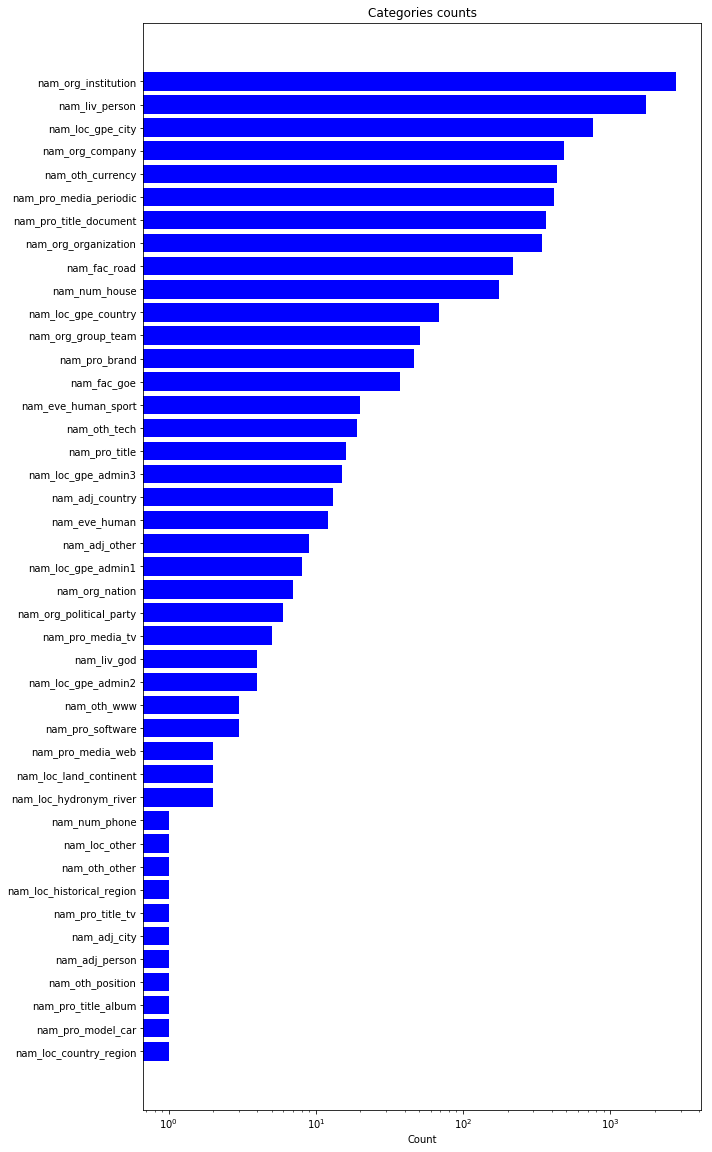

In [31]:
plot_counts(categories_counter)

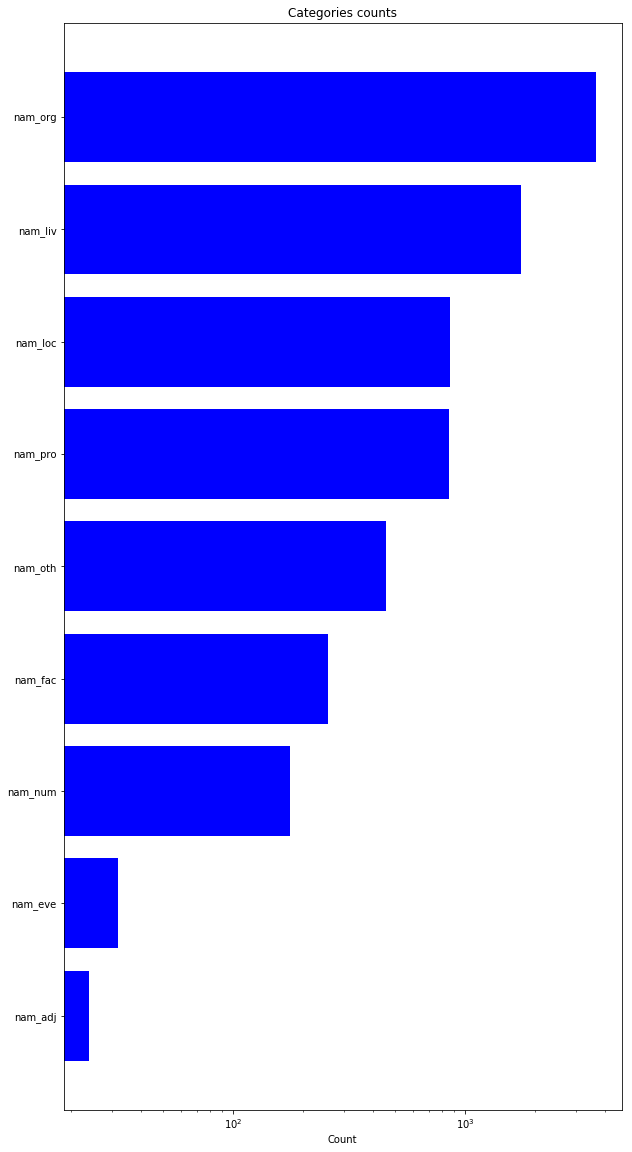

In [32]:
plot_counts(general_categories_counter)

In [33]:
for expression, count in Counter(expressions).most_common(100):
    print(count, expression)

425 Expression(original_form='Sąd Najwyższy', base_form='sąd najwyższy', full_category_name='nam_org_institution')
422 Expression(original_form='Zamawiający', base_form='zamawiać', full_category_name='nam_liv_person')
385 Expression(original_form='zł', base_form='złoty', full_category_name='nam_oth_currency')
324 Expression(original_form='Trybunału Konstytucyjnego', base_form='trybunał konstytucyjny', full_category_name='nam_org_institution')
274 Expression(original_form='Sądu Okręgowego', base_form='sąd okręgowy', full_category_name='nam_org_institution')
263 Expression(original_form='Warszawie', base_form='Warszawa', full_category_name='nam_loc_gpe_city')
248 Expression(original_form='Dz . U .', base_form='dziennik . u .', full_category_name='nam_pro_media_periodic')
190 Expression(original_form='Sąd Apelacyjny', base_form='sąd apelacyjny', full_category_name='nam_org_institution')
165 Expression(original_form='Odwołującego', base_form='odwoływać', full_category_name='nam_liv_person'

In [34]:
for category in general_categories_counter:
    expressions_for_category = [expression for expression in expressions if expression.general_category_name == category]
    print(category)
    for expression, count in Counter(expressions_for_category).most_common(10): 
        print(count, expression)
    print()

nam_org
425 Expression(original_form='Sąd Najwyższy', base_form='sąd najwyższy', full_category_name='nam_org_institution')
324 Expression(original_form='Trybunału Konstytucyjnego', base_form='trybunał konstytucyjny', full_category_name='nam_org_institution')
274 Expression(original_form='Sądu Okręgowego', base_form='sąd okręgowy', full_category_name='nam_org_institution')
190 Expression(original_form='Sąd Apelacyjny', base_form='sąd apelacyjny', full_category_name='nam_org_institution')
121 Expression(original_form='Sądu Rejonowego', base_form='sąd rejonowy', full_category_name='nam_org_institution')
110 Expression(original_form='TK', base_form='TK', full_category_name='nam_org_institution')
105 Expression(original_form='Krajowa Izba Odwoławcza', base_form='krajowy izba odwoławczy', full_category_name='nam_org_institution')
102 Expression(original_form='Urzędu Zamówień Publicznych', base_form='urząd zamówienie publiczny', full_category_name='nam_org_institution')
86 Expression(original